In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os, sys
from nltk.tokenize import TweetTokenizer
import tqdm
import re
import copy


import matplotlib
import matplotlib.pyplot as plt

import tqdm

from wordcloud import WordCloud

import gc
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix


import pickle

#import cudf #turn on gpu to work

import seaborn as sns
color = sns.color_palette()

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split




%matplotlib inline

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
#sample = pd.read_csv("sample.csv")



In [6]:
test_new = test.join(train, on='Id', how = 'inner',lsuffix='test_data', rsuffix='train_new')

In [7]:
train.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha..."
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...


<AxesSubplot:title={'center':'Scores'}>

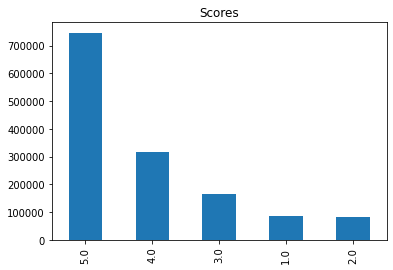

In [8]:
plt.title('Scores')
train['Score'].value_counts().plot.bar()

In [9]:
stop = ['a','an','the','and','this','that']

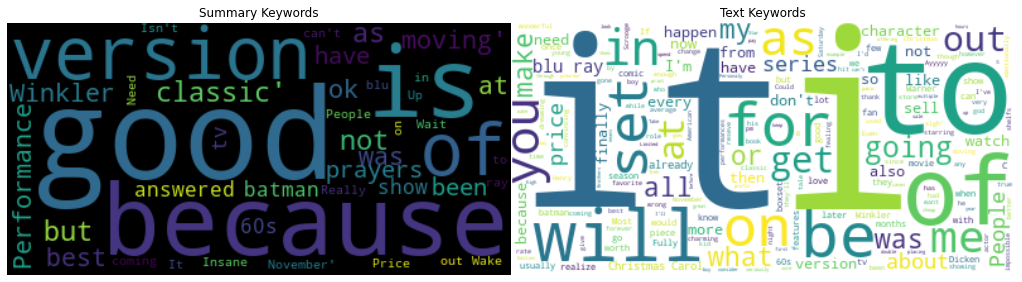

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(121)
text = train.Summary.values
wordcloud = WordCloud(
    background_color = 'black',
    stopwords = stop).generate(str(text))
plt.title('Summary Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax = fig.add_subplot(122)
text = train.Text.values
wordcloud = WordCloud(
    background_color = 'white',
    stopwords = stop).generate(str(text))
plt.title('Text Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing Train Data

In [11]:
train = train[['Score','Text']]

train = train.dropna() #dropping Null values
train.head()

,Score,Text
0,4.0,This is a charming version of the classic Dick...
1,3.0,It was good but not as emotionally moving as t...
2,3.0,"Don't get me wrong, Winkler is a wonderful cha..."
3,5.0,Henry Winkler is very good in this twist on th...
4,4.0,This is one of the best Scrooge movies out. H...


In [12]:
#Converting sentences to tokens for text processing
p = re.compile(r'[^\w\s]+')
#train['Text'] = [p.sub('', x) for x in tqdm.tqdm_notebook(train['Text'].to_arrow().to_pylist())] #gpu
train['Text'] = [p.sub('', x) for x in tqdm.tqdm_notebook(train['Text'].tolist())] #cpu

train['Text'] = train['Text'].str.lower().str.split()


#Remove Stop words

stop = ['a','an','the','and','this','that']

#stop = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', 'what', 'which', 'who','whom','why', 'how', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",'hasn',"hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn'"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',"wasn't",
#'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't"]

train['Text'] = tqdm.tqdm_notebook(train['Text'].apply(lambda x: [item for item in x if item not in stop])) #cpu

train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1397480 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1397480 [00:00<?, ?it/s]

,Score,Text
0,4.0,"[is, charming, version, of, classic, dickens, ..."
1,3.0,"[it, was, good, but, not, as, emotionally, mov..."
2,3.0,"[dont, get, me, wrong, winkler, is, wonderful,..."
3,5.0,"[henry, winkler, is, very, good, in, twist, on..."
4,4.0,"[is, one, of, best, scrooge, movies, out, henr..."


In [13]:
train1 = copy.deepcopy(train)

train1['Text'] = train1['Text'].apply(', '.join)

#converting tocken back to sentences

p1 = re.compile(r'[^\w\s]+')
train1['Text'] = [p1.sub('', x) for x in tqdm.tqdm_notebook(train1['Text'].tolist())]
train1['Text'] = train1['Text'].str.lower()
train1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1397480 [00:00<?, ?it/s]

,Score,Text
0,4.0,is charming version of classic dickens tale he...
1,3.0,it was good but not as emotionally moving as c...
2,3.0,dont get me wrong winkler is wonderful charact...
3,5.0,henry winkler is very good in twist on classic...
4,4.0,is one of best scrooge movies out henry winkle...


In [13]:
#train1.to_csv('data/train_preprocess.csv',index= False)

## Preprocessing Test data

In [14]:


test_text = test_new[['Id','Text']]

test_text = test_text.dropna()

p1 = re.compile(r'[^\w\s]+')
#splitting the words
test_text['Text'] = [p1.sub('', x) for x in tqdm.tqdm_notebook(test_text['Text'].tolist())]

#making all string lowercase
test_text['Text'] = test_text['Text'].str.lower().str.split()

test_text['Text'] = test_text['Text'].apply(', '.join)

#combining all of together to make one string

p2 = re.compile(r'[^\w\s]+')
test_text['Text'] = [p2.sub('', x) for x in test_text['Text'].tolist()]
test_text['Text'] = test_text['Text'].str.lower()

#test_text.to_csv('data/test_preprocess.csv',index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/299991 [00:00<?, ?it/s]

In [15]:
#train1 = pd.read_csv("data/train_preprocess.csv")
#test1 = pd.read_csv("data/test_preprocess.csv")

In [15]:
#Local Train and test set.

X_train,X_test,y_train,y_test = train_test_split(train1['Text'],train1['Score'],test_size=0.1, random_state=42)

In [16]:
#whole dataset

X_train_whole = train1['Text']
y_train_whole = train1['Score']

In [17]:
def save_model(text_clf,save_name = 'model.pkl'):
    with open(save_name, 'wb') as files:
        pickle.dump(text_clf, files)

## Support Vector Machine

Experiment:
1. Train the SVM with data with these stop words ['a','an','the','and','this','that'] removed from the dataset and used TfidfVectorizer().

2. Train the SVM with data with only stop = ['a','an','the','and','this','that'] removed from the dataset and used TfidfVectorizer().

In [13]:

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC(dual=False,C = 0.2,verbose =3))])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

[LibLinear]iter  1 act 2.152e+05 pre 2.152e+05 delta 8.484e-01 f 2.795e+05 |g| 5.072e+05 CG   1
cg reaches trust region boundary
iter  2 act 3.316e+03 pre 3.316e+03 delta 2.978e+00 f 6.434e+04 |g| 4.558e+03 CG   1
cg reaches trust region boundary
iter  3 act 7.246e+03 pre 6.781e+03 delta 4.597e+00 f 6.102e+04 |g| 5.782e+03 CG   2
cg reaches trust region boundary
iter  4 act 6.222e+03 pre 5.411e+03 delta 5.728e+00 f 5.378e+04 |g| 7.739e+03 CG   3
cg reaches trust region boundary
iter  5 act 4.472e+03 pre 4.014e+03 delta 7.918e+00 f 4.756e+04 |g| 1.100e+04 CG   4
iter  6 act 1.017e+02 pre 9.895e+01 delta 7.918e+00 f 4.308e+04 |g| 7.603e+03 CG   1
cg reaches trust region boundary
iter  7 act 2.387e+03 pre 2.178e+03 delta 9.846e+00 f 4.298e+04 |g| 6.309e+02 CG   4
cg reaches trust region boundary
iter  8 act 1.567e+03 pre 1.524e+03 delta 1.120e+01 f 4.060e+04 |g| 3.431e+03 CG   5
cg reaches trust region boundary
iter  9 act 1.224e+03 pre 1.148e+03 delta 1.323e+01 f 3.903e+04 |g| 2.322e+03 

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(C=0.2, dual=False, verbose=3))])

In [19]:
save_model(text_clf,save_name = 'svm_model_tfidf_big_stop.pkl')

In [32]:
#trains forever
text_clf = Pipeline([('CountVectorizer', CountVectorizer()),
                     ('clf', LinearSVC(dual=False,C = 0.2,verbose =3)),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

KeyboardInterrupt: 

In [ ]:
save_model(save_name = 'svm_model_count_vec_big_stop.pkl',text_clf)

In [18]:
svm_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC(dual=False,C = 0.2,verbose =3))])

svm_clf.fit(X_train, y_train)

[LibLinear]iter  1 act 1.936e+05 pre 1.936e+05 delta 8.576e-01 f 2.515e+05 |g| 4.516e+05 CG   1
cg reaches trust region boundary
iter  2 act 3.097e+03 pre 3.097e+03 delta 3.430e+00 f 5.791e+04 |g| 4.122e+03 CG   1
cg reaches trust region boundary
iter  3 act 7.448e+03 pre 6.818e+03 delta 5.120e+00 f 5.481e+04 |g| 5.234e+03 CG   2
cg reaches trust region boundary
iter  4 act 5.957e+03 pre 5.300e+03 delta 6.974e+00 f 4.736e+04 |g| 8.604e+03 CG   3
cg reaches trust region boundary
iter  5 act 3.515e+03 pre 3.020e+03 delta 8.851e+00 f 4.141e+04 |g| 8.787e+03 CG   4
iter  6 act 1.092e+02 pre 1.060e+02 delta 8.851e+00 f 3.789e+04 |g| 6.992e+03 CG   1
cg reaches trust region boundary
iter  7 act 1.895e+03 pre 1.791e+03 delta 1.061e+01 f 3.778e+04 |g| 5.052e+02 CG   4
cg reaches trust region boundary
iter  8 act 1.367e+03 pre 1.307e+03 delta 1.273e+01 f 3.589e+04 |g| 2.342e+03 CG   6
cg reaches trust region boundary
iter  9 act 1.025e+03 pre 9.993e+02 delta 1.451e+01 f 3.452e+04 |g| 1.765e+03 

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.2, dual=False, verbose=3))])

In [29]:
pred = svm_clf.predict(X_test)

array([5., 5., 4., ..., 5., 4., 5.])

In [ ]:
# check accuracy
print(accuracy_score(y_test, pred))

# check confusion matrix
print(confusion_matrix(y_test, pred))

# check classification report
print(classification_report(y_test, pred))

In [21]:
save_model(svm_clf,save_name = 'svm_model_count_vec_tfid_big_stop.pkl')

## Pipelining Random Forest Classifier for training with TF-IDF Vectorizer

In [19]:
train2 = train1.sample(frac=1)

In [20]:
one = train2[train2['Score']==1][:84000]
two = train2[train2['Score']==2][:84000]
three = train2[train2['Score']==3][:84000]
four = train2[train2['Score']==4][:84000]
five = train2[train2['Score']==5][:84000]


df = pd.concat([one, two,three,four,five], ignore_index=True)

In [8]:
X_train2 = train2['Text']
y_train2 = train2['Score']

In [ ]:
#Random Forest

text_clf1 = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier(n_estimators=100,random_state=0,verbose =2))])

# Feed the training data through the pipeline
text_clf1.fit(X_train[:40000], y_train[:40000]) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


In [40]:
pred = text_clf1.predict(X_test)
accuracy_score(pred,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished


0.5355210808025875

In [22]:
X_train2 = df['Text']
y_train2 = df['Score']

In [ ]:
text_clf2 = Pipeline([('tfidf', TfidfVectorizer()),
                     ('rdf',RandomForestClassifier(verbose =2)),
])

# Feed the training data through the pipeline
text_clf2.fit(X_train2, y_train2) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


In [25]:
pred = text_clf2.predict(X_test)
# check accuracy
print(accuracy_score(y_test, pred))

# check confusion matrix
print(confusion_matrix(y_test, pred))

# check classification report
print(classification_report(y_test, pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


NameError: name 'accuracy_score' is not defined

In [27]:
accuracy_score(pred,y_test)

0.061067063571571684

## Logistic Regression #did not train 

In [ ]:

from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression(random_state = 0,verbose =3))])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

## Get results to submit

In [23]:
test_text = pd.read_csv("../input/amazon-review-preprocessed-data/test_preprocess.csv")

In [24]:
train_new = pd.read_csv("../input/cs506-fall-2022/train.csv")

In [25]:
test_new = test.join(train_new, on='Id', how = 'inner',lsuffix='test_data', rsuffix='train_new')

In [36]:
predictions = text_clf1.predict(test_text['Text'])
submission_2 = pd.DataFrame({'Id':test_text['Id'],'Score':predictions})
#Visualize the first 5 rows
submission_2.head()

common = test_text.merge(submission_2,on=['Id'])
common=test_new[(~test_new['Id'].isin(common['Id']))]
common_id_score = common[['Id','Scoretest_data']]
common_id_score = common_id_score.rename(columns = {"Scoretest_data":"Score"})

common_id_score.head()
submission_2_new = submission_2.append(common_id_score)
submission_2_new['Score'].fillna((submission_2_new['Score'].mean()), inplace=True)

submission_2_new=submission_2_new.astype(int)
submission_2_new.to_csv('submit_rf_full_data.csv',index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   30.8s finished


Getting results for SVM

In [ ]:
predictions = text_clf.predict(test_text['Text'])
submission_2 = pd.DataFrame({'Id':test_text['Id'],'Score':predictions})
#Visualize the first 5 rows
submission_2.head()

common = test_new.merge(submission_2,on=['Id'])
common=test_new[(~test_new['Id'].isin(common['Id']))]
common_id_score = common[['Id','Scoretest_data']]
common_id_score = common_id_score.rename(columns = {"Scoretest_data":"Score"})

common_id_score.head()
submission_2_new = submission_2.append(common_id_score)
submission_2_new['Score'].fillna((submission_2_new['Score'].mean()), inplace=True)

submission_2_new=submission_2_new.astype(int)
submission_2_new.to_csv('svm_results.csv')

Random forest results

In [ ]:
predictions = text_clf2.predict(test_text['Text'])
submission_2 = pd.DataFrame({'Id':test_text['Id'],'Score':predictions})
#Visualize the first 5 rows
submission_2.head()

common = test_new.merge(submission_2,on=['Id'])
common=test_new[(~test_new['Id'].isin(common['Id']))]
common_id_score = common[['Id','Scoretest_data']]
common_id_score = common_id_score.rename(columns = {"Scoretest_data":"Score"})

common_id_score.head()
submission_2_new = submission_2.append(common_id_score)
submission_2_new['Score'].fillna((submission_2_new['Score'].mean()), inplace=True)

submission_2_new=submission_2_new.astype(int)
submission_2_new.to_csv('rf_results.csv',index=False)

In [ ]:
submission_2_new.to_csv('rf_results.csv',index=False)

## Creating ensemble of all models generated

In [ ]:
svm_1 = pd.read_csv('result/submit_svm_full_data.csv')
svm_2 = pd.read_csv('result/submit_svm_model_tfidf_big_stop.csv')
svm_3 = pd.read_csv('result/submit_svm_count_vec_tfid_big_stop.csv')
rf_1 = pd.read_csv('result/submit_rf_40k_cls_balance.csv')
rf_2 = pd.read_csv('result/submit_rf_50k_cls_balance.csv')
rf_3 = pd.read_csv('result/submit_rf_full_data.csv')

In [ ]:
#Mode:
#ensemble_pred = []
#for i in range(len(svm_1['Score'])):
#        ensemble_pred.append(np.argmax(np.bincount([svm_1['Score'][i], svm_2['Score'][i], svm_3['Score'][i]])))

#Weighted Score:

weighted_score = (0.25*svm_1['Score']+0.2*svm_2['Score']+0.25*svm_3['Score']+0.1*rf_1['Score']+0.1*rf_2['Score']+0.1*rf_3['Score']) #/6

submit =pd.DataFrame()
submit['Id'] = svm_1['Id']
submit['Score'] = weighted_score
submit = submit.astype('int')
submit.to_csv('ensemble_svm_rf_6_weighted.csv',index=False)

# Train with GPU (Did not work, issue with pipline)

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#set CUDA_PATH=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.4
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import gc
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import cudf #turn on gpu to work
from cuml.ensemble import RandomForestRegressor


import os, sys
from nltk.tokenize import TweetTokenizer

import matplotlib
import matplotlib.pyplot as plt

import cudf #turn on gpu to work

import seaborn as sns
color = sns.color_palette()
import re

import tqdm

%matplotlib inline

# Any results you write to the current directory are saved as output.

In [8]:
train = cudf.read_csv("../input/amazon-review-preprocessed-data/train_preprocess.csv")
test = cudf.read_csv("../input/amazon-review-preprocessed-data/test_preprocess.csv")
#sample = pd.read_csv("sample.csv")

In [35]:
from cuml.pipeline import Pipeline
from cuml.feature_extraction.text import TfidfVectorizer
#from cuml.svm import linear_svc

from cuml.ensemble import RandomForestClassifier

In [28]:
model = TfidfVectorizer()
text_embeddings = model.fit_transform(train['Text']).toarray()
print('text embeddings shape is',text_embeddings.shape)

MemoryError: std::bad_alloc: CUDA error at: /opt/conda/include/rmm/mr/device/cuda_memory_resource.hpp:70: cudaErrorMemoryAllocation out of memory

In [10]:
train.head()

,Score,Text
0,4.0,"['is', 'charming', 'version', 'of', 'classic',..."
1,3.0,"['it', 'was', 'good', 'but', 'not', 'as', 'emo..."
2,3.0,"['dont', 'get', 'me', 'wrong', 'winkler', 'is'..."
3,5.0,"['henry', 'winkler', 'is', 'very', 'good', 'in..."
4,4.0,"['is', 'one', 'of', 'best', 'scrooge', 'movies..."


In [13]:
train['Text']

0          ['is', 'charming', 'version', 'of', 'classic',...
1          ['it', 'was', 'good', 'but', 'not', 'as', 'emo...
2          ['dont', 'get', 'me', 'wrong', 'winkler', 'is'...
3          ['henry', 'winkler', 'is', 'very', 'good', 'in...
4          ['is', 'one', 'of', 'best', 'scrooge', 'movies...
                                 ...                        
1397475    ['looking', 'very', 'much', 'forward', 'to', '...
1397476    ['finally', 'holy', 'grail', 'of', 'tvondvd', ...
1397477    ['could', 'be', 'true', 'or', 'im', 'i', 'drea...
1397478    ['ive', 'been', 'fan', 'of', 'series', 'since'...
1397479    ['people', 'seriously', 'need', 'to', 'wake', ...
Name: Text, Length: 1397480, dtype: object

In [23]:
p1 = re.compile(r'[^\w\s]+')
train['Text'] = [p1.sub('', x) for x in tqdm.tqdm_notebook(train['Text'].to_pandas().tolist())]
train['Text'] = train['Text'].str.lower()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1397480 [00:00<?, ?it/s]

In [26]:
train['Score']

0          4.0
1          3.0
2          3.0
3          5.0
4          4.0
          ... 
1397475    4.0
1397476    5.0
1397477    5.0
1397478    5.0
1397479    5.0
Name: Score, Length: 1397480, dtype: float64

In [36]:
text_clf2 = Pipeline([('tfidf', TfidfVectorizer()),
                     ('rdf',RandomForestClassifier(verbose =2)),
])

# Feed the training data through the pipeline
text_clf2.fit(train['Text'].to_pandas(), train['Score'].to_pandas()) 

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [ ]:


text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC(dual=False,C = 0.2,verbose =3)),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

In [34]:
train.to_csv('train_preprocess.csv',index=False)